In [28]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from tqdm import tqdm
from bitsandbobs.plt import set_size


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

# data_dir = "../../../gnode/experiment_analysis/dat/"
# data_dir = "../data"
# data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"
data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")


2024-05-25 02:55:47,566 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [4]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-25 02:42:53,150 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2024-05-25 02:42:53,152 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [20]:
# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R > 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-25 02:51:40,580 | INFO     | notebook | <module> | removed 240 rows due to unexpected timescales


2024-05-25 03:00:21,412 | INFO     | plot_helper | panel_stimulus_violins | violins for R_tot, ['natural_movie_one_more_repeats' 'spontaneous'], N=4926
2024-05-25 03:00:21,420 | INFO     | plot_helper | panel_stimulus_violins | natural_movie_one_more_repeats vs spontaneous diff=-22.5% p=9.501786608750611e-238
2024-05-25 03:00:21,933 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats median: 0.0801 quantiles: [0.07836677 0.08166085] from 500 samples of length 4926
2024-05-25 03:00:21,934 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats min: 0.0019 max: 0.37
2024-05-25 03:00:22,387 | DEBUG    | plot_helper | fancy_violins | spontaneous median: 0.0627 quantiles: [0.06155898 0.06417019] from 500 samples of length 4926
2024-05-25 03:00:22,388 | DEBUG    | plot_helper | fancy_violins | spontaneous min: 0.00094 max: 0.47
2024-05-25 03:00:22,396 | DEBUG    | plot_helper | fancy_violins | plotting 800 points for cat stimulus
2024-05-25 03:00:22,53

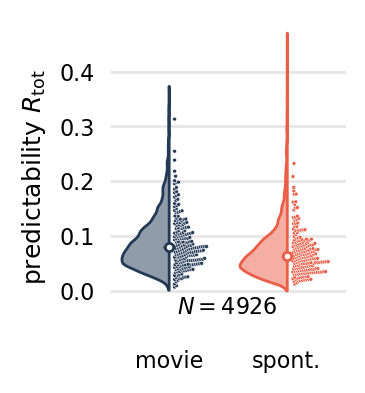

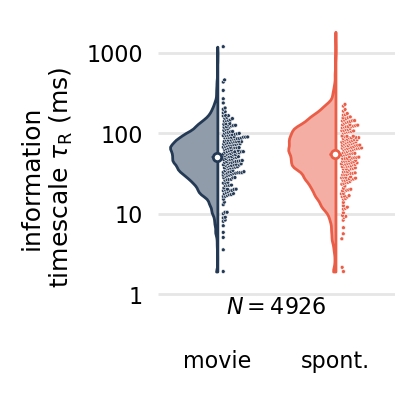

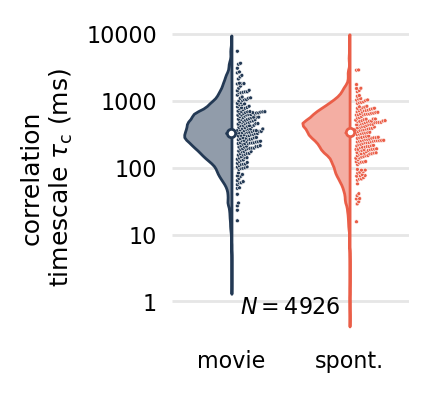

In [42]:

for obs in ["R_tot", "tau_R", "tau_double"]:
    ax = ph.panel_stimulus_violins(
        df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']"),
        observable = obs,
        logscale=False if obs == "R_tot" else True,
        category = "stimulus",
        num_swarm_points=400,
        xlabels = ['movie', 'spont.'],
        # specify palette to make sure labels are correct!
        palette={
                "natural_movie_one_more_repeats" : "#233954",
                "spontaneous" : "#EA5E48",
            },
    )
    set_size(ax, w=3.0, h=4.0)


In [7]:
meta_df.query("stimulus == 'natural_movie_three'")

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9590,951107970,natural_movie_three,799864342,merged_3.0_and_6.0,VISrl,SUCCESS,1079.928955,32.036367,/project.nst/neuroscience-raw/Allen/visual_cod...,34597,...,0.031869,0.690854,0.154603,"{'firing_rate': 31.94188512218384, 'firing_rat...","{'tau': 0.6908540702336606, 'mre': 0.992788708...","{'tau': 0.1546029986918742, 'mre': 0.968176475...",0.020588,0.200576,0.629805,True
9591,951107988,natural_movie_three,799864342,merged_3.0_and_6.0,VISrl,SUCCESS,1078.979004,3.008400,/project.nst/neuroscience-raw/Allen/visual_cod...,3246,...,0.104847,0.737027,0.737051,"{'firing_rate': 3.0046896142653248, 'firing_ra...","{'tau': 0.7370267575797173, 'mre': 0.993238945...","{'tau': 0.7370512365491423, 'mre': 0.993239169...",0.016947,0.605864,0.088491,True
9592,951108012,natural_movie_three,799864342,merged_3.0_and_6.0,VISrl,SUCCESS,1079.152100,6.707118,/project.nst/neuroscience-raw/Allen/visual_cod...,7238,...,0.055608,0.646828,0.646828,"{'firing_rate': 6.637600715374529, 'firing_rat...","{'tau': 0.646828176798839, 'mre': 0.9922997717...","{'tau': 0.6468278222467588, 'mre': 0.992299767...",0.070800,0.469492,0.815357,False
9593,951108504,natural_movie_three,799864342,merged_3.0_and_6.0,VISrl,SUCCESS,1068.996338,1.467732,/project.nst/neuroscience-raw/Allen/visual_cod...,1569,...,0.092372,0.552390,0.532599,"{'firing_rate': 1.4658559401309634, 'firing_ra...","{'tau': 0.5523904113096452, 'mre': 0.990989272...","{'tau': 0.5325990216145297, 'mre': 0.990656003...",0.202666,0.551949,0.787027,True


2024-05-25 02:59:38,007 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-25 02:59:38,015 | INFO     | plot_helper | panel_selectivity_scatter | r: 0.346, p: 2.4e-170, m: 0.143, b: 0.067
2024-05-25 02:59:38,024 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-25 02:59:38,032 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.048, p: 0.00016, m: -26.182, b: 68.527
2024-05-25 02:59:38,041 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-25 02:59:38,047 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.095, p: 9.8e-14, m: -668.518, b: 642.706


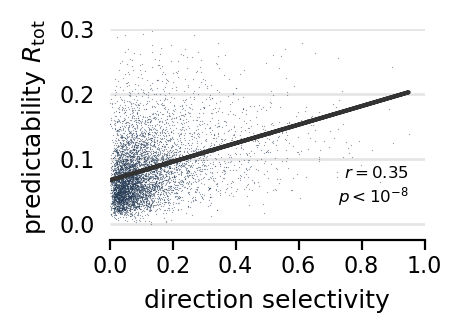

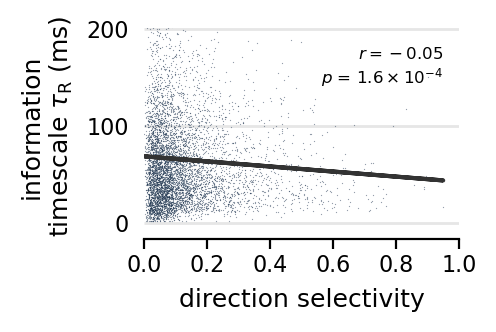

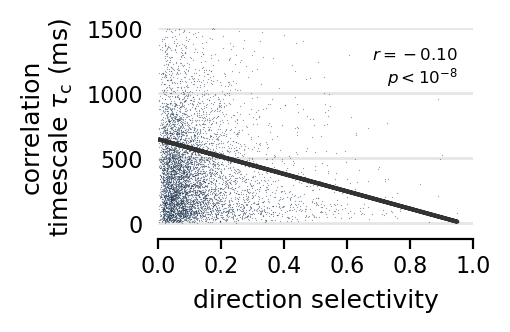

In [41]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    ax = ph.panel_selectivity_scatter(
        df = meta_df.query("stimulus == 'natural_movie_three'"),
        observable = obs,
    )
    set_size(ax, w=4.0, h=2.5)


In [ ]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

scipy: 1.13.0

matplotlib    : 3.8.4
logging       : 0.5.1.2
prompt_toolkit: 3.0.42
numpy         : 1.24.4
scipy         : 1.13.0
h5py          : 3.11.0
re            : 2.2.1
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
sqlite3       : 2.6.0
IPython       : 8.22.2
xarray        : 2024.3.0
pandas        : 2.0.3
dask          : 2024.4.2

